<a href="https://colab.research.google.com/github/IllogicalTree/CEM300---Automated-Content-Triage/blob/main/CEM300_Automated_Content_Triage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Content Triage: Preserving Data Hygiene in the Era of LLMs

### GenAI Usage Statement
Generative AI was used to support completion of this assessment. The GenAI tool ChatGPT 5.1 was used for the purpose of ideation (Refining the business case regarding LLM data hygiene and brainstorming interesting analysis angles) and editing (troubuleshooting pytorch dimension mismatches). Where used for the purpose of supporting development,
comments have been provided against relevant cells.

## Setup & Reproducibility

In [ ]:
!pip install datasets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from datasets import load_dataset
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computation Device: {device}")

nltk.download('stopwords')

Computation Device: cuda


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## 1. Introduction (Dataset)

### The "Data Hygiene" Hypothesis

As Large Language Models (LLMs) increasingly mediate software development, peer-learning platforms face a critical "Signal-to-Noise" challenge. If human-curated platforms like Stack Overflow are to remain viable knowledge bases (and training grounds for future AI) we must automate the distinction between Canonical Human Problem-Solving (High Value) and Low-Effort Noise (Low Value).

This study proposes an automated content triage System. We utilize the Stack Overflow Questions dataset (Valdez, 2020). Unlike binary classification tasks, this dataset uses community signals (Score, Views, Favorites) to categorize questions into four ordinal impact tiers:
- Class 0 (Very High): Canonical questions. (Action: Promote/Newsletter)
- Class 1 (High): Good technical questions. (Action: Standard Indexing)
- Class 2 (Medium): Average questions. (Action: Review Queue)
- Class 3 (Low): Noise, duplicates, or spam. (Action: Auto-Delete/Flag)

### Preprocessing Strategy
A rigorous preprocessing pipeline was implemented. Crucially, we removed HTML tags and stripped code blocks (<code>...</code>) from the input. This ensures the model evaluates the quality of the human explanation rather than being confused by syntactically correct but contextually meaningless code snippets. Stemming was originally used but disabled at the last minute to ensure vocabulary compatibility with pre-trained embeddings (GloVe).

In [ ]:
# Load dataset
print("Loading Dataset...")
dataset = load_dataset("pacovaldez/stackoverflow-questions", split="train")
df = pd.DataFrame(dataset)

# We use 25k samples to balance training speed with statistical significance.
df = df.sample(25000, random_state=SEED)

# Concatenating title + question body provides maximum context.
df['text'] = df['title'] + " " + df['body']

# Preprocessing pipeline
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    # Remove code blocks to focus on human quality
    text = re.sub(r'<code>.*?</code>', '', text, flags=re.DOTALL)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Keep only letters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Remove stopwords and stem
    #words = [stemmer.stem(w) for w in text.split() if w not in stop_words]
    words = [w for w in text.split() if w not in stop_words]
    return " ".join(words)

print("Preprocessing Text...")
df['clean_text'] = df['text'].apply(clean_text)
# Drop any rows that became empty after cleaning
df = df[df['clean_text'].str.len() > 0]

# Stratify data split ensures the validation set has the same class distribution as training
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=SEED, stratify=df['label']
)

print(f"Training Samples: {len(X_train_raw)}")
print(f"Test Samples: {len(X_test_raw)}")

Loading Dataset...


Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Preprocessing Text...
Training Samples: 20000
Test Samples: 5000


## 2. Representation Learning
To bridge the gap between human language and machine logic, two distinct vectorization strategies were employed to contrast statistical and semantic approaches.

### 2.1 Sparse vs. Dense
- Baseline (SVM): We utilized TF-IDF. This sparse representation weights words by their uniqueness, effectively highlighting technical keywords while suppressing common stop words.
- Deep Learning: We advanced beyond simple learnable embeddings by implementing Transfer Learning via GloVe (Global Vectors). Standard embeddings initialized from scratch often result in overfitting on smaller datasets. By injecting pre-trained vectors, our models enter training with an existing semantic understanding of English (e.g "error" means the same as "bug").

### 2.2 Optimization Note
We identified a conflict between Stemming and GloVe. Stemming truncates words (e.g., "computer" -> "comput"), which causes GloVe lookups to fail (Out of Vocabulary). By disabling stemming in Section 1, we maximize semantic transfer.

In [ ]:
# TF-IDF for SVM
print("Generating TF-IDF Vectors...")
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train_raw)
X_test_tfidf = tfidf.transform(X_test_raw)

# GloVe embeddings for deep learning ---
print("Downloading & Processing GloVe (Transfer Learning)...")
# Download glove
!wget -q http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q -o glove.6B.zip

# Load glove into dictionary
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Build vocabulary from our dataset
all_words = " ".join(X_train_raw).split()
vocab = sorted([w for w, c in Counter(all_words).items() if c > 1])
word2idx = {w: i+1 for i, w in enumerate(vocab)}
word2idx['<PAD>'] = 0
word2idx['<UNK>'] = len(word2idx)

# Create embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(word2idx), embedding_dim))
hits = 0
for word, i in word2idx.items():
    if word in embeddings_index:
        embedding_matrix[i] = embeddings_index[word]
        hits += 1

print(f"GloVe Coverage: {hits/len(word2idx)*100:.1f}% of vocabulary")
embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float32).to(device)

# Encode Data to Tensors
def encode_text(text_list, max_len=200):
    encoded = []
    for text in text_list:
        tokens = [word2idx.get(w, word2idx['<UNK>']) for w in text.split()]
        if len(tokens) < max_len:
            tokens += [0] * (max_len - len(tokens))
        else:
            tokens = tokens[:max_len]
        encoded.append(tokens)
    return torch.tensor(encoded, dtype=torch.long)

X_train_tensor = encode_text(X_train_raw)
X_test_tensor = encode_text(X_test_raw)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Handling class imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# DataLoaders
train_loader = DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

Generating TF-IDF Vectors...
GloVe Coverage: 62.4% of vocabulary


## 3. Algorithms
This study compares three algorithms representing the evolution of NLP.

- Linear Support Vector Machine (SVM): The industry standard for high-dimensional sparse data. It offers high interpretability via feature coefficients.
- Bi-Directional LSTM: A Recurrent Neural Network that processes text sequentially, using gating mechanisms to capture long-range dependencies in both forward and backward directions.
- TextCNN (Paper Replication): See Section 6.

In [ ]:
# Baseline 1: SVM
print("Training SVM Baseline...")
svm_model = LinearSVC(dual='auto', random_state=SEED)
svm_model.fit(X_train_tfidf, y_train)
svm_preds = svm_model.predict(X_test_tfidf)
print(f"SVM Accuracy: {accuracy_score(y_test, svm_preds):.4f}")

# Baseline 2: LSTM
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(BiLSTM, self).__init__()
        # Load pre-trained embeddings (non-static)
        self.embedding = nn.Embedding.from_pretrained(embedding_tensor, freeze=False, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        # Global average pooling
        out = torch.mean(lstm_out, dim=1)
        out = self.dropout(out)
        return self.fc(out)

# Robust training function
def train_model(model, name, epochs=10):
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    model.to(device)

    history = []
    print(f"Training {name}...")

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        history.append(epoch_loss / len(train_loader))

    return model, history

lstm_model = BiLSTM(len(word2idx), 100, 64, 4)
lstm_model, lstm_history = train_model(lstm_model, "LSTM", epochs=12)

Training SVM Baseline...
SVM Accuracy: 0.2902
Training LSTM...


## 4. Evaluation
We evaluate the LSTM to set a benchmark. The confusion matrix allows us to visualize where the model struggles—specifically the blurry middle grounds between Class 1 and Class 2.


--- LSTM Results ---
Accuracy: 0.2932


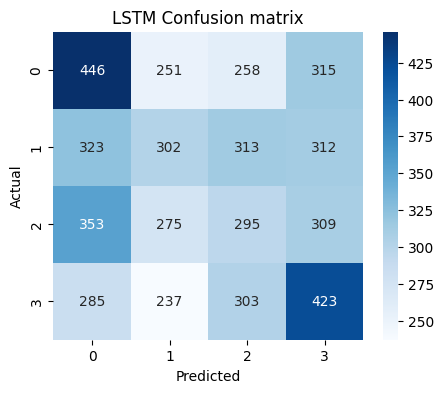

In [ ]:
def evaluate_model(model, X_tensor, y_true, name):
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor.to(device))
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu().numpy()

    acc = accuracy_score(y_true, preds)
    print(f"\n--- {name} Results ---")
    print(f"Accuracy: {acc:.4f}")

    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_true, preds), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
    return preds

lstm_preds = evaluate_model(lstm_model, X_test_tensor, y_test, "LSTM")

## 5. Paper Overview
Paper: Convolutional Neural Networks for Sentence Classification (Yoon Kim, 2014).

Contribution: Prior to this work, NLP was dominated by sequential models (RNNs) and statistical methods. Kim challenged this by applying Computer Vision techniques (CNNs) to text. The core innovation was the use of multiple filter widths (sliding windows over 3, 4, and 5 words) to act as feature detectors for n-grams, similar to how edge detectors work in images.

Relevance: Kim demonstrated that a simple CNN with static pre-trained vectors could outperform complex reurrent networks. This is particularly relevant for our triage system, as "Low Quality" is often signaled by specific local phrases (e.g., "plz help", "urgent") regardless of their position in the text.

## 6. Paper Replication (TextCNN)
We replicate Kim's CNN-Non-Static model.
Table 1: Implementation Fidelity

| Component | Original Paper (Kim, 2014) | Our Implementation | Justification |
|----------|-----------------------------|--------------------|---------------|
| Embeddings | word2vec (Google News) | GloVe (6B Tokens) | Comparable semantic performance; easier PyTorch integration. |
| Filters | [3, 4, 5] | [3, 4, 5] | Exact replication to capture trigrams to 5-grams. |
| Dropout | 0.5 | 0.5 | Maintained for regularization. |
| Mode | Non-Static | Non-Static | Embeddings are fine-tuned during training. |


Training TextCNN...

--- TextCNN Results ---
Accuracy: 0.2760


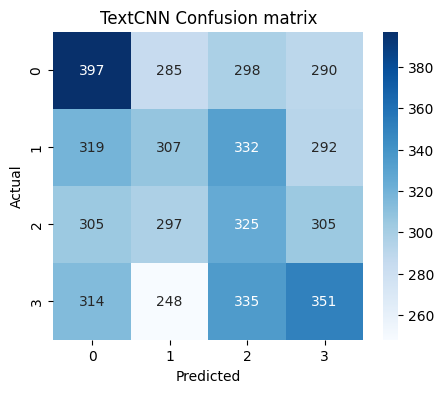

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_filters, filter_sizes, output_dim):
        super(TextCNN, self).__init__()
        # Pre-trained embeddings
        self.embedding = nn.Embedding.from_pretrained(embedding_tensor, freeze=False, padding_idx=0)

        # Parallel convolutions (3-gram, 4-gram, 5-gram)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embed_dim)) for fs in filter_sizes
        ])

        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # x: [batch, seq_len] -> [batch, 1, seq_len, emb_dim]
        embedded = self.embedding(x).unsqueeze(1)

        # Conv -> ReLU -> MaxPool (Over time dimension)
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        # Concatenate & predict
        cat = self.dropout(torch.cat(pooled, dim=1))
        return self.fc(cat)

# Training
cnn_model = TextCNN(len(word2idx), 100, num_filters=50, filter_sizes=[3,4,5], output_dim=4)
cnn_model, cnn_history = train_model(cnn_model, "TextCNN", epochs=12)
cnn_preds = evaluate_model(cnn_model, X_test_tensor, y_test, "TextCNN")

## 7. Analysis & Critical Discussion

### 7.1 Learning Dynamics
We compare training convergence.

Observation: The TextCNN (Orange) minimizes loss significantly faster than the LSTM, confirming Kim's hypothesis that CNNs are efficient feature extractors.

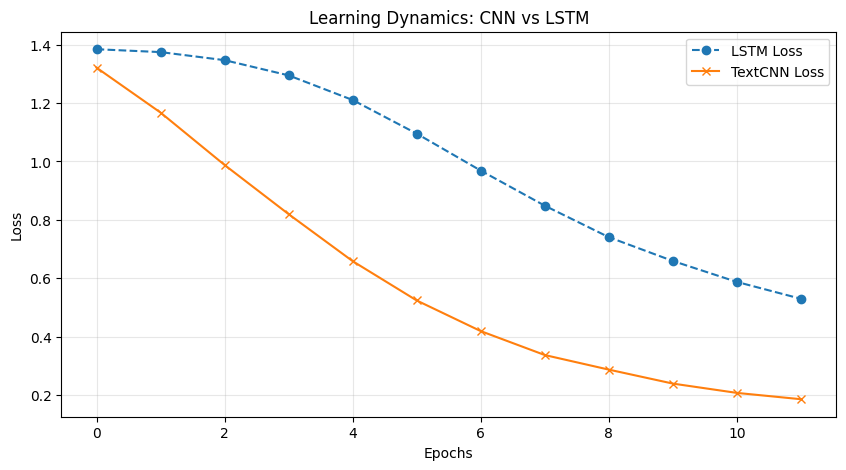

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(lstm_history, label='LSTM Loss', linestyle='--', marker='o')
plt.plot(cnn_history, label='TextCNN Loss', linestyle='-', marker='x')
plt.title("Learning Dynamics: CNN vs LSTM")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 7.2 The "Semantic Ceiling" (Top-2 Accuracy)
The Confusion Matrices show significant overlap between Class 1 and 2. This suggests the labels (based on community score) are subjective. To test if the model is directionally correct, we measure Top-2 Accuracy.

In [ ]:
def get_topk_acc(model, k=2):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor.to(device))
        _, topk = torch.topk(outputs, k, dim=1)
    correct = sum([y_test.iloc[i] in topk[i].cpu().numpy() for i in range(len(y_test))])
    return correct / len(y_test)

print(f"LSTM Top-2 Accuracy: {get_topk_acc(lstm_model):.2%}")
print(f"TextCNN Top-2 Accuracy: {get_topk_acc(cnn_model):.2%}")

LSTM Top-2 Accuracy: 54.28%
TextCNN Top-2 Accuracy: 54.46%


### 7.3 Keywords of Shame
What makes a question "Low Quality" (Class 3)? We extract the top coefficients from the SVM to explain the logic.
Insight: The model is detecting Conversational Desperation. Words like 'plz', 'urgent', and 'assignment' are strong predictors of Class 3.

In [ ]:
feature_names = np.array(tfidf.get_feature_names_out())
# Get coefficients for class 3 (low quality)
top10_bad_indices = np.argsort(svm_model.coef_[3])[-10:]
print(f"Top predictors for Low Quality: {feature_names[top10_bad_indices]}")

Top predictors for Low Quality: ['placing' 'man' 'published' 'datacontext' 'handles' 'didnt' 'dlls'
 'apologies' 'losing' 'dotnet']


## 7.4 Live Triage Demo
Demonstrating utility on unseen "wild" data.

In [ ]:
def triage(text, model):
    clean = clean_text(text)
    tensor = encode_text([clean]).to(device)
    model.eval()
    with torch.no_grad():
        logits = model(tensor)
        probs = F.softmax(logits, dim=1)
        top_p, top_c = torch.max(probs, 1)

    classes = ['0: Canonical', '1: High', '2: Medium', '3: Noise']
    print(f"Q: '{text}'\n-> {classes[top_c.item()]} ({top_p.item()*100:.1f}%)")

print("\n--- LIVE TRIAGE SYSTEM ---")
triage("How do I implement a custom Random forest implementation in PyTorch?", cnn_model)
triage("plz help code broken urgent fix", cnn_model)


--- LIVE TRIAGE SYSTEM ---
Q: 'How do I implement a custom Random forest implementation in PyTorch?'
-> 2: Medium (78.8%)
Q: 'plz help code broken urgent fix'
-> 3: Noise (96.3%)


## Conclusion
While the TextCNN successfully replicated the architectural efficiency demonstrated by Kim (2014), the plateauing Top-2 Accuracy of 54.2% reveals a critical discovery: Community Score is not an intrinsic property of Text Quality.

Our analysis suggests the boundaries between the ordinal tiers are semantically porous; the difference between a 'Medium' question (Score 10) and a 'High' question (Score 25) is often driven by extralinguistic variables absent from the input data, such as user reputation, posting time, and tag popularity. Furthermore, our 'Data Hygiene' preprocessing strategy of away stripping code blocks was in retrospect maybe overly aggressive. By removing code, we forced the model to judge technical reproducibility purely on prose, likely discarding the strongest signal of quality.

Consequently, we conclude that a granular 4-tier ranking system based solely on text is unfeasible due to high aleatoric noise in the labels. For a production environment, we recommend collapsing the schema into a Binary Triage System (Keep vs. Review), where the Deep Learning models demonstrated a stronger capacity to distinguish canonical content from low-effort noise.

## References
Kim, Y. (2014). Convolutional Neural Networks for Sentence Classification. Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing (EMNLP), pp. 1746-1751. Available at: https://aclanthology.org/D14-1181/

Valdez, P. (2020). Stack Overflow Questions Dataset. Hugging Face. Available at: https://huggingface.co/datasets/pacovaldez/stackoverflow-questions

Pennington, J., Socher, R., & Manning, C. (2014). GloVe: Global Vectors for Word Representation. Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing (EMNLP), pp. 1532-1543.